## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from cup1d.data import data_MPGADGET
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
emu_type="polyfit"
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.45 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
#free_param_names=["As","ns","ln_tau_0"]
free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]

In [7]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=None)

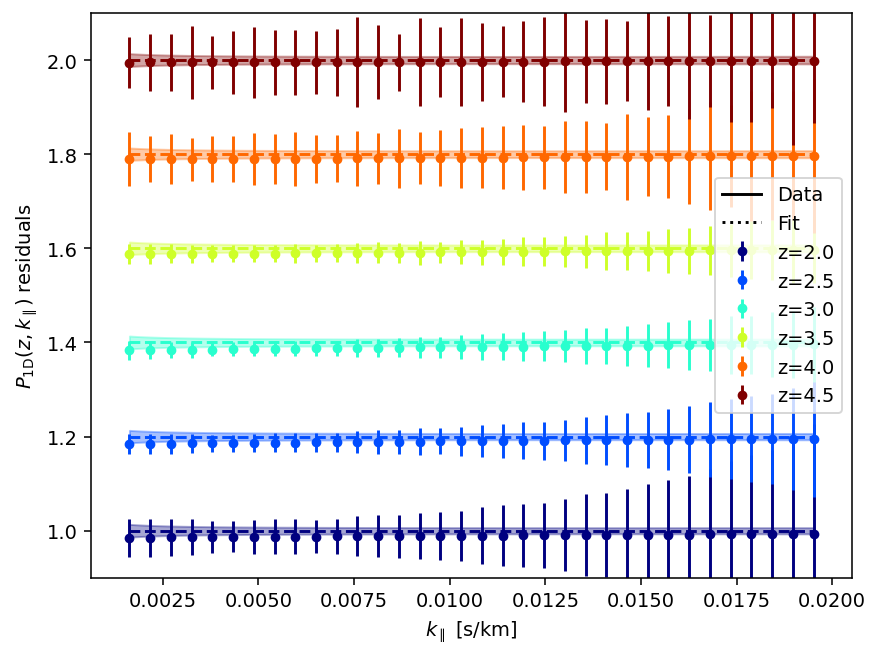

In [8]:
like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [10]:
minimizer.minimize(compute_hesse=True)

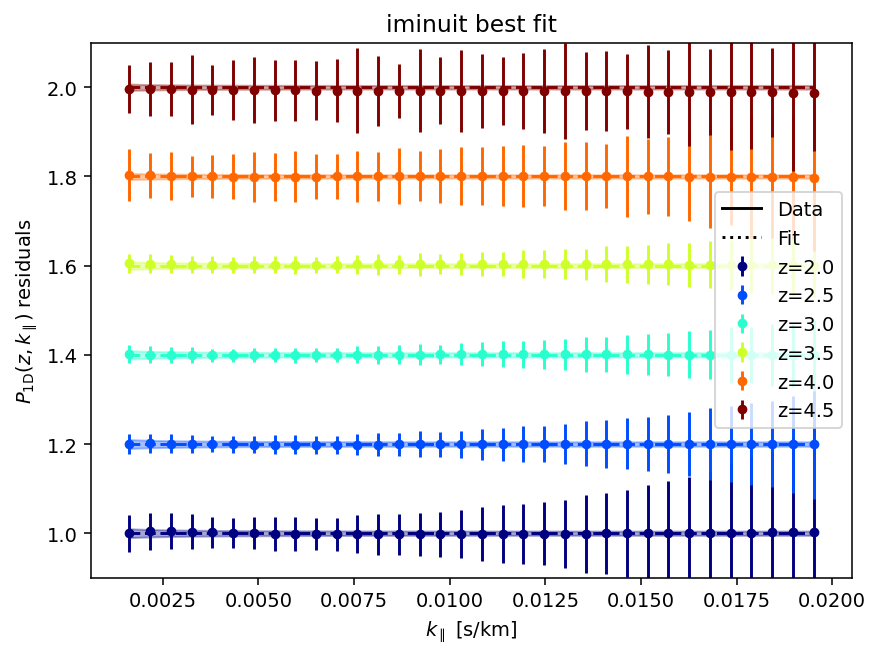

In [11]:
minimizer.plot_best_fit(plot_every_iz=2)

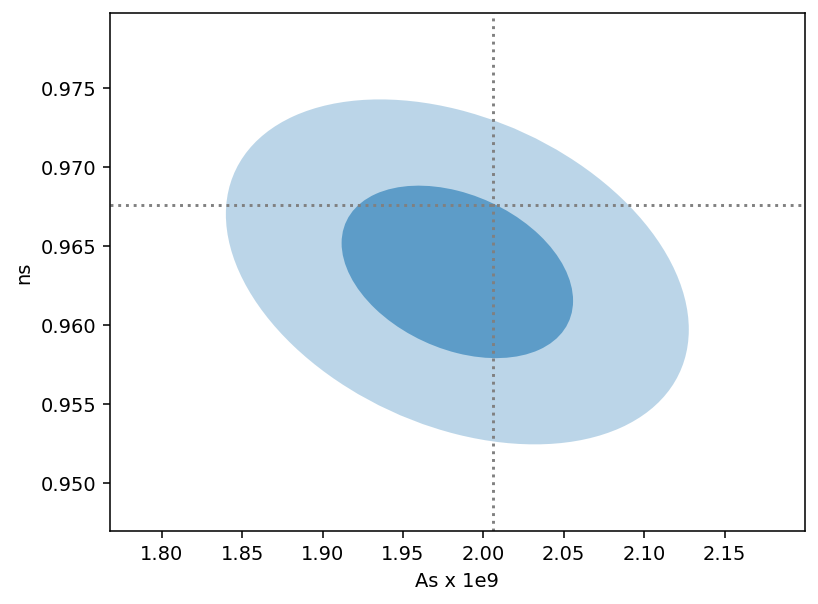

In [12]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [13]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 120.6                      │              Nfcn = 596              │
│ EDM = 9.22e-10 (Goal: 0.0001)    │            time = 8.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.447   │   0.033   │            │            │         │         │       │
│ 1 │ x1   │   0.490   │   0.032   │            │            │         │         │       │
│ 2 │ x2   │   0.65    │   0.06    │            │            │         │         │       │
│ 3 │ x3   │   0.52    │   0.15    │            │            │         │         │       │
│ 4 │ x4   │   0.38    │   0.29    │            │            │         │         │       │
│ 5 │ x5   │   0.41    │   0.06    │            │            │         │         │       │
│ 6 │ x6   │   0.60    │   0.06    │            │            │         │         │       │
│ 7 │ x7   │   0.48    │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00107 -0.000351  -0.00128 -0.000227  0.000751  0.000696  0.000821  0.000671 │
│ x1 │ -0.000351   0.00103 -0.000139 -0.000693  0.000781 -0.000213 -0.000483 -0.000764 │
│ x2 │  -0.00128 -0.000139   0.00401   0.00123  -0.00341  -0.00294   0.00044  -0.00167 │
│ x3 │ -0.000227 -0.000693   0.00123    0.0213   -0.0335  -0.00162  -0.00121    0.0158 │
│ x4 │  0.000751  0.000781  -0.00341   -0.0335    0.0846   0.00238    0.0027   -0.0111 │
│ x5 │  0.000696 -0.000213  -0.00294  -0.00162   0.00238   0.00328 -1.92e-05   0.00133 │
│ x6 │  0.000821 -0.000483   0.00044  -0.00121    0.0027 -1.92e-05   0.00317   0.00111 │
│ x7 │  0.000671 -0.000764  -0.00167    0.0158   -0.0111   0.00133   0.00111    0.0274 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

In [14]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [15]:
#minimizer.minimizer.draw_mnprofile("x0")